This notebook follows "metropolis-hastingsMCMC" and uses the Metropolis-Hastings MCMC algorithm that we developed last time to explore the parameter space for a dataset where the model has several parameters.

In [73]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.gridspec as gridspec

The following function is a general MCMC walker that can be applied to *any* functional form and set of data, if you provide it with the appropriate function to calculate $\chi^2$.  Read it over carefully and make sure you understand how it corresponds to the code we wrote yesterday!

In [165]:
def mhMCMC(xi, yi, err, chi2func, initparams, stepsize, nsteps):
    ''' Performs a Markov Chain Monte Carlo chain using the Metropolis-Hastings algorithm
        to explore the parameter space for the given model and data.  Returns the sequence
        of steps taken.
    
        Input
        =====
        xi : An array giving the x-values of the data
        yi : An array giving the y-values of the data
        err : An array giving the errors on the data.  
              May be 1xN (for y-errors only) or 2xN (for x- and y- errors), 
              must match what's expected by chi2func.
        chi2func : A function which calculates the chi-squared between the data
                   and model.  Must take arguments (params, xi, yi, err).
        initparams : An array [a0, a1, a2...] giving the initial position in parameter space.
        stepsize : An array [da0, da1, da2...] giving the sigma of the normal distributions
                   from which the steps are drawn.  Must be the same length as initparams.
        nsteps : The number of steps to take.
                
        Returns
        =======
        p : An array of positions in parameter space, with dimensions (nsteps+1, nparams)
    '''
    p = initparams
    plist = [p]
    
    for i in range(0,nsteps):
        # Draw a step size for each parameter
        dp = np.zeros(len(p))
        for j in range(0,len(p)):
            if stepsize[j] > 0: dp[j] = np.random.normal(scale=stepsize[j])
            
        # Check out the chi2 at the new location
        if chi2func(p + dp, xi, yi, err) < chi2func(p, xi, yi, err):
            # Accept the step if the likelihood is higher
            p = p + dp
        else:
            # Evaluate the likelihood ratio
            r = np.math.exp((chi2func(p, xi, yi, err) - chi2func(p + dp, xi, yi, err))/2.)
            # Accept the step if the random number drawn is lower than the likelihood ratio
            u = np.random.uniform(0., 1.)
            if r > u:
                p = p + dp
    
        plist.append(p)

    return np.array(plist)

**Exercise 1**

Today we are going to use this MCMC function to fit a set of data with a functional form that is significantly more complicated than the straight line we have worked with before.  The code below reads in and plots the data from a file "data.npy":

<Container object of 3 artists>

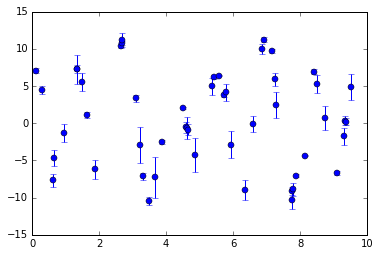

In [173]:
data = np.load("data.npy")
xdata = data[0,:]
ydata = data[1,:]
err = data[2,:]

plt.errorbar(xdata, ydata, yerr=yerr, fmt='o')

Clearly, a straight line isn't going to cut it!  This data is actually best described by the superposition of two periodic functions, $y = p_0 \cos(p_1 x) + p_2 \sin(p_3 x)$.  Now we have four free parameters instead of two!  

(And in reality, you would have six - including a phase angle for each sinusoid - but I've given you $\phi_1$ = $\phi_2$ = 0 for free.  Believe it or not, this is actually a plausible functional form for a signal produced by an astrophysical object, and the sort of thing you could encounter in your research.)

Below I have written a function that finds the $y$-values given a set of $x$-values and an array of parameters $p = [p_0, p_1, p_2, p_3]$.

**To do:** Implement a function which calculates the $\chi^2$ between this model with a given set of parameters, and a set of $(x,y,\sigma_y)$ data.  Try out a few sets of parameter values and see how low you can get the $\chi^2$ with the manual-guess-and-check method.  You can also plot the function with your trial parameters on top of the data for a "chi-by-eye".

Hints:
- It would be best to return a *reduced* $\chi^2$, which has the number of degrees of freedom (i.e., the number of data points - 1) divided out. 
- Think about whether there are any regions of parameter space you'd like to exclude.  If there are, returning "np.infty" will forbid the MCMC walker from wandering there.

401.944960279
227.673138547
936.073107235


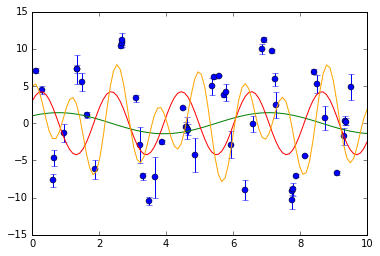

In [174]:
def crazyfunction(p, x):
    y = p[0]*np.cos(p[1]*x) + p[2]*np.sin(p[3]*x)
    return y

def chi2crazyfunction(p, x, y, err):
    # YOUR CODE HERE
    if np.sum(p < 0) > 0: return np.infty
    chi2 = np.sum((crazyfunction(p,x) - y)**2/(err**2))/(len(x)-1)
    return chi2

plt.errorbar(xdata, ydata, yerr=yerr, fmt='o')
xplot = np.linspace(0,10,100)
yplot = crazyfunction(np.array([1., 1., 1., 1.]), xplot)
print(chi2crazyfunction(np.array([1., 1., 1., 1.]), xdata, ydata, err))
plt.plot(xplot, yplot, color='green')
yplot = crazyfunction(np.array([3., 3., 3., 3.]), xplot)
print(chi2crazyfunction(np.array([3., 3., 3., 3.]), xdata, ydata, err))
plt.plot(xplot, yplot, color='red')
yplot = crazyfunction(np.array([5., 5., 3., 3.]), xplot)
print(chi2crazyfunction(np.array([5., 5., 5., 5.]), xdata, ydata, err))
plt.plot(xplot, yplot, color='orange')

**Exercise 2**

Now, instead of continuing to mess around manually, or calculating the likelihoods throughout the whole 4-dimensional parameter space, we can MCMC walk our way around the space and map the probabilities!

**To do:** Define an initial location in parameter space, a typical step size for each parameter, and the total number of steps you'd like to take.  Then, run the MCMC function above using the $\chi^2$ function you just wrote and the data we have read in.

In [186]:
# FINISH THESE LINES
# Initial location
pinit = np.array([1, 1, 1, 1])
# Step sizes (sigmas of normal distributions)
stepsize = np.array([0.5, 0.5, 0.5, 0.5])
# Total number of steps to take
nsteps = 1000000

p = mhMCMC(xdata, ydata, yerr, chi2crazyfunction, pinit, stepsize, nsteps)

It is important to always *take a look* at your output so that you can see what happened.  I've set up a plotting routine below that creates four panels stacked on top of one another (one for each parameter).  

**To do:** Fill in the lines to plot the evolution of each parameter, and take a look at the output.  Does the MCMC walker move gradually up or down from its initial location, then settle around a constant value?  (This initial period is called *burn-in*.)  As always, take some time to play with the step sizes, initial location, and number of steps.

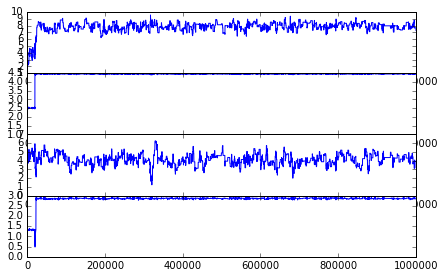

In [187]:
gs1 = gridspec.GridSpec(4,1)
gs1.update(left=0.07, right=0.97, top=0.95, bottom=0.1, hspace=0, wspace=0.)
ax = plt.subplot(gs1[0,0])
# Plot parameter 0
plt.plot(p[:,0])
ax = plt.subplot(gs1[1,0])
# Plot parameter 1
plt.plot(p[:,1])
ax = plt.subplot(gs1[2,0])
# Plot parameter 2
plt.plot(p[:,2])
ax = plt.subplot(gs1[3,0])
# Plot parameter 3
plt.plot(p[:,3])

**To do:** What is the median value of each parameter, *after* burn-in?  Plot the function with these median values on top of the data.  How does the fit look?

[ 7.93279956  4.4514613   4.12714145  2.85706677]


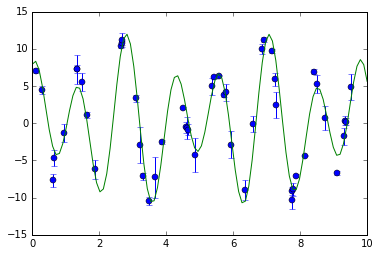

In [188]:
# YOUR CODE HERE
pmeds = np.array([np.median(p[:,0]), np.median(p[:,1]), np.median(p[:,2]), np.median(p[:,3])])
print(pmeds)
xplot = np.linspace(0,10,100)
yplot = crazyfunction(pmeds, xplot)
plt.errorbar(xdata, ydata, yerr=yerr, fmt='o')
plt.plot(xplot, yplot, color='green')

Recall that the Metropolis-Hastings algorithm has the property of *ergodicity*, meaning that with a large enough number of steps, the walker will trace out the underlying probability space.  

**To do:** Finish the code below to plot the histogram of the locations visited by the walker for each of the four parameters.  Anything interesting?

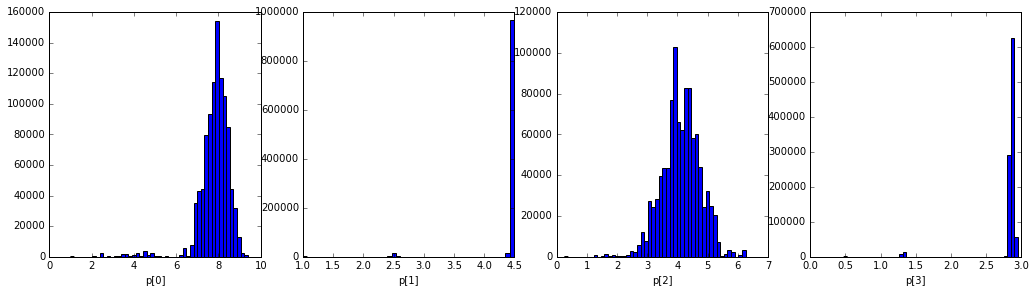

In [189]:
plt.figure(figsize=(15,4))
gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.07, right=0.97, top=0.95, bottom=0.1, hspace=0, wspace=0.2)
for i in range(0,4):
    ax = plt.subplot(gs1[0,i])
    # Your code here - plot the histogram of the i'th parameter
    plt.hist(p[:,i], bins=50)
    ax.set_xlabel('p['+str(i)+']')

By plotting 2d histograms, you can also see how any two parameters are related.  The code below computes and plots a 2d histogram for p[0] and p[2].  Take a look!

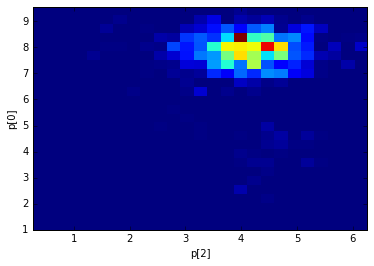

In [192]:
hist, xedges, yedges = np.histogram2d(p[:,0], p[:,2], bins=25)
plt.imshow(np.flipud(hist), interpolation='nearest', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]], aspect='auto')
plt.xlabel('p[2]')
plt.ylabel('p[0]')

**Bonus goals**

- You may have noticed that some parameters are more well-constrained than others.  To get a better estimate of the harder-to-constrain parameters, you can rerun the MCMC with some parameters fixed in place, i.e. with step size = 0.  Give it a try!

- We have not discussed what happens if you have **priors** on the parameter values, i.e. you know that some values are more likely than others.  Let's say we had a prior for p[0] that was a Gaussian centered on 7.  How would you go about implementing this prior probability?  How would the probability space change?

In [128]:
# Initial location
pinit = np.array([5, 4.5, 5, 2.9])
# Step sizes (sigmas of normal distributions)
stepsize = np.array([0.5, 0., 0.5, 0.])
# Total number of steps to take
nsteps = 100000

p = mhMCMC(xdata, ydata, yerr, chi2crazyfunction, pinit, stepsize, nsteps)

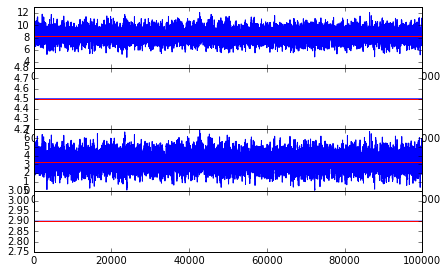

In [129]:
gs1 = gridspec.GridSpec(4,1)
gs1.update(left=0.07, right=0.97, top=0.95, bottom=0.1, hspace=0, wspace=0.)
ax = plt.subplot(gs1[0,0])
plt.plot(p[:,0])
plt.plot([0,100000], [8.2, 8.2], color='red')
ax = plt.subplot(gs1[1,0])
plt.plot(p[:,1])
plt.plot([0,100000], [4.5, 4.5], color='red')
ax = plt.subplot(gs1[2,0])
plt.plot(p[:,2])
plt.plot([0,100000], [3.3, 3.3], color='red')
ax = plt.subplot(gs1[3,0])
plt.plot(p[:,3])
plt.plot([0,100000], [2.9, 2.9], color='red')

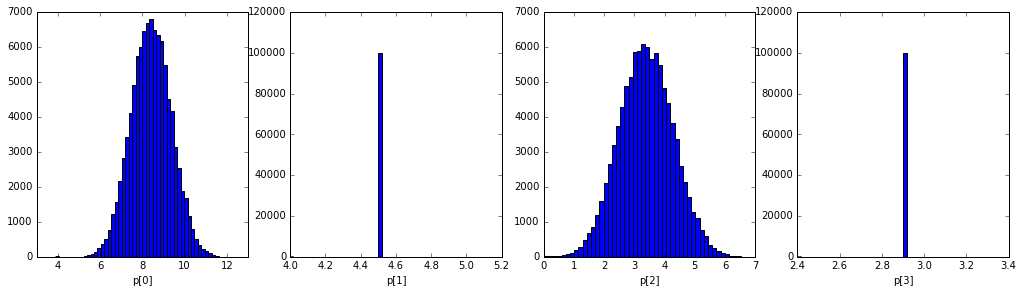

In [130]:
plt.figure(figsize=(15,4))
gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.07, right=0.97, top=0.95, bottom=0.1, hspace=0, wspace=0.2)
for i in range(0,4):
    ax = plt.subplot(gs1[0,i])
    plt.hist(p[:,i], bins=50)
    ax.set_xlabel('p['+str(i)+']')

If you are curious, here is the code I used to generate the dataset.

In [145]:
params = np.array([8.2, 4.5, 3.3, 2.9])
xplot = np.linspace(0, 10, 200)
yplot = crazyfunction(params, xplot)

xdata = np.random.uniform(0, 10, size=50)
xdata = np.array(sorted(xdata))
ydata = crazyfunction(params, xdata)

yerr = np.abs(np.random.normal(scale=1., size=50))
nsmall = np.sum(yerr < 0.2)
if nsmall > 0:
    yerr[yerr < 0.2] = np.abs(np.random.normal(scale=1., size=nsmall))

dy = np.array([np.random.normal(scale=sig) for sig in yerr])
print(np.min(np.abs(dy)), np.max(dy))
ydata = ydata + dy

#np.save("data.npy", np.array([xdata, ydata, yerr]))

0.0367635814339 3.63601984115
